Epoch 1/20
83670/83670 ━━━━━━━━━━━━━━━━━━━━ 157s 2ms/step - accuracy: 0.9961 - loss: 0.0121 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 2/20
83670/83670 ━━━━━━━━━━━━━━━━━━━━ 156s 2ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 0.9998 - val_loss: 6.7759e-04
Epoch 3/20
83670/83670 ━━━━━━━━━━━━━━━━━━━━ 160s 2ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9999 - val_loss: 5.5737e-04
Epoch 4/20
83670/83670 ━━━━━━━━━━━━━━━━━━━━ 159s 2ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9999 - val_loss: 4.7167e-04
Epoch 5/20
83670/83670 ━━━━━━━━━━━━━━━━━━━━ 158s 2ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9999 - val_loss: 3.3728e-04
Epoch 6/20
83670/83670 ━━━━━━━━━━━━━━━━━━━━ 158s 2ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9999 - val_loss: 3.9388e-04
Epoch 7/20
83670/83670 ━━━━━━━━━━━━━━━━━━━━ 157s 2ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9999 - val_loss: 3.2799e-04
Epoch 8/20
83670/83670 ━━━━━━━━━━━━━━━

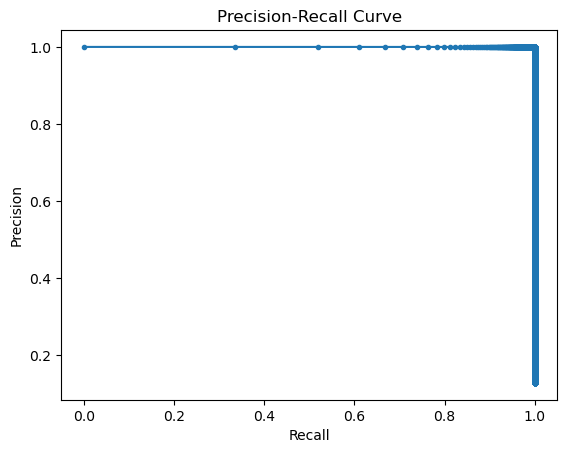

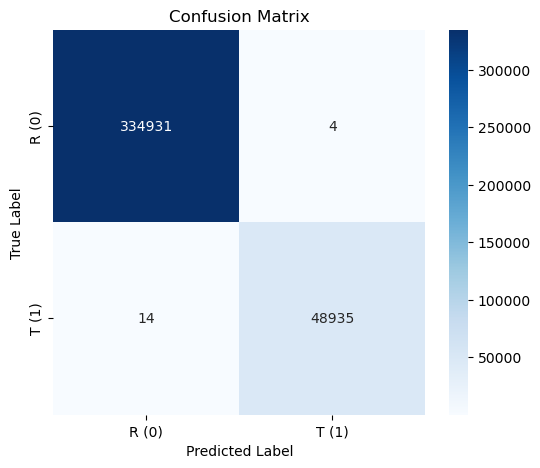

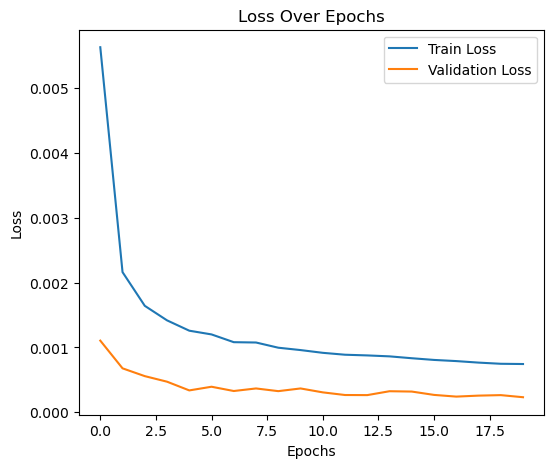

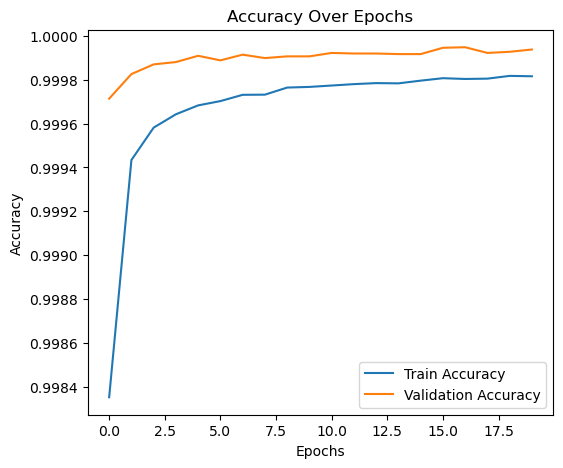

Evaluating Neural Network Model...
Train Accuracy: 1.0000
Validation Accuracy: 0.9999
Test Accuracy: 1.0000
Generalization Error: 0.0000

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    334935
           1       1.00      1.00      1.00     48949

    accuracy                           1.00    383884
   macro avg       1.00      1.00      1.00    383884
weighted avg       1.00      1.00      1.00    383884



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.layers import BatchNormalization 
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split

# 데이터 경로 설정
data_paths = ['/Users/jiwoo/Desktop/개인 프로젝트/data6/Fuzzy_dataset.csv']

# 열 이름 설정
column_names = ['Timestamp', 'ID', 'Length', 'Data1', 'Data2', 'Data3', 'Data4', 
                'Data5', 'Data6', 'Data7', 'Data8', 'label']

# 데이터 로드 및 병합
dfs = []
for path in data_paths:
    df = pd.read_csv(path, names=column_names, dtype={'Timestamp': str})
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# 1. 'R', 'T'를 label로 이동, 나머지는 결측값 처리
for i in range(1, 9):  
    data_col = f'Data{i}'
    df['label'] = np.where(df[data_col].isin(['R', 'T']), df[data_col], df['label'])
    df[data_col] = np.where(df[data_col].isin(['R', 'T']), np.nan, df[data_col])

# 결측값을 -1로 대체
data_columns = [f'Data{i}' for i in range(1, 9)]
df[data_columns] = df[data_columns].fillna(-1)

# 2. Timestamp 변환 및 시간 차이 계산
df['Timestamp'] = df['Timestamp'].astype(float)
df['Timestamp'] = df['Timestamp'].diff().fillna(0).round(6) * 1e6  
df['Timestamp'] = df['Timestamp'].astype(int)

# 3. ID 라벨 인코딩
label_encoder = LabelEncoder()
df['ID'] = label_encoder.fit_transform(df['ID'])

# 4. Data1 ~ Data8 16진수 → 10진수 변환
def hex_to_int(value):
    if isinstance(value, str):  
        if value == '-1':
            return int(value)
        try:
            return int(value, 16)
        except ValueError:
            return value  
    return value  

for col in data_columns:
    df[col] = df[col].apply(hex_to_int)

# 5. 라벨 변환 ('R' → 0, 'T' → 1)
df['label'] = df['label'].apply(lambda x: 0 if x == 'R' else (1 if x == 'T' else x))

# 데이터 분리
X = df.drop(['label'], axis=1)
Y = df[['label']]

# 6. 데이터셋 분할 (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

# 7. SMOTE-Tomek을 사용한 클래스 불균형 해결
smote_tomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# 데이터 정규화 (StandardScaler 사용)
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_resampled = y_resampled.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

# ✅ 3개의 연속된 행을 하나의 샘플로 변환하는 함수
def create_3d_data(X, Y, window_size=3):
    X_reshaped, Y_reshaped = [], []
    for i in range(len(X) - window_size + 1):
        X_reshaped.append(X[i:i+window_size])
        Y_reshaped.append(Y[i+window_size-1])
    return np.array(X_reshaped), np.array(Y_reshaped)

# 데이터를 3D 형태로 변환
X_resampled, y_resampled = create_3d_data(X_resampled, y_resampled)
X_val, y_val = create_3d_data(X_val, y_val)
X_test, y_test = create_3d_data(X_test, y_test)

# CNN 입력 형태로 변환
X_resampled = X_resampled.reshape(-1, 3, X_resampled.shape[2], 1)  
X_val = X_val.reshape(-1, 3, X_val.shape[2], 1)
X_test = X_test.reshape(-1, 3, X_test.shape[2], 1)

# ✅ CNN 모델 정의
model = Sequential([
    Input(shape=(3, X_resampled.shape[2], 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),  # ✅ BatchNormalization 추가
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.3),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),  # ✅ BatchNormalization 추가
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),  # ✅ BatchNormalization 추가
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(
    X_resampled, y_resampled,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)


# 평가
train_accuracy = model.evaluate(X_resampled, y_resampled, verbose=0)[1]
val_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]
test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

# 예측
y_val_pred = (model.predict(X_val) > 0.5).astype(int)
y_test_pred = (model.predict(X_test) > 0.5).astype(int)


y_scores = model.predict(X_test).ravel()
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


# ✅ 오차 행렬(Confusion Matrix) 시각화
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['R (0)', 'T (1)'], yticklabels=['R (0)', 'T (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ✅ 손실 그래프
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# ✅ 정확도 그래프
plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

# 결과 출력
print("Evaluating Neural Network Model...")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Generalization Error: {1 - test_accuracy:.4f}\n")

print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred))
